# Anova-Homework
## Gowlapalli Rohit - 2021101113

In [34]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, f_oneway , chi2 , kruskal , t , mannwhitneyu
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import f
from scipy.stats import ttest_ind
from scipy.stats import kstest
import pingouin as pg
from statsmodels.stats.multitest import multipletests
import scikit_posthocs as sp

# Memory Scores

In [35]:
# Do children with neurodevelopmental disorders have lower memory scores?
data_normal = np.array([24, 22, 19, 22, 28, 26, 28, 24, 30, 29, 25, 20, 17, 19, 18, 26, 27, 24, 27, 27])
data_autistic = np.array([15, 2, 1, 21, 3, 10, 9, 8, 3, 7, 6, 18, 2, 5, 2, 5, 0, 27])
data_epilepsy = np.array([30, 15, 34, 26, 14, 28, 17, 29, 25, 11, 37, 36, 34, 22, 18, 5, 12, 10,15])
data_disorder = np.concatenate((data_autistic, data_epilepsy))

##### Null Hypothesis (H0): There is no significant difference in memory scores among children with different neurodevelopmental disorders.

##### Alternative Hypothesis (H1): Children with neurodevelopmental disorders (such as Autism and Epilepsy) have lower memory scores compared to children without these disorders.

In [36]:
group_stats = {
    'Groups': ['Normal', 'Autistic', 'Epilepsy','Disorder'],
    'Count': [len(data_normal), len(data_autistic), len(data_epilepsy),len(data_disorder)],
    'Sum': [data_normal.sum(), data_autistic.sum(), data_epilepsy.sum(),data_disorder.sum()],
    'Average': [data_normal.mean(), data_autistic.mean(), data_epilepsy.mean(),data_disorder.mean()],
    'Variance': [data_normal.var(), data_autistic.var(), data_epilepsy.var(),data_disorder.var()],
}
group_stats_df = pd.DataFrame(group_stats)
print(group_stats_df) 

     Groups  Count  Sum    Average    Variance
0    Normal     20  482  24.100000   14.390000
1  Autistic     18  144   8.000000   54.333333
2  Epilepsy     19  418  22.000000   91.578947
3  Disorder     37  562  15.189189  122.423667


## Check for Normality

In [37]:
shapiro_normality_tests = {}
for temp_data in data_normal, data_autistic, data_epilepsy, data_disorder:
    stat, p = shapiro(temp_data)
    col = 'Normal' if temp_data is data_normal else 'Autistic' if temp_data is data_autistic else 'Epilepsy' if temp_data is data_epilepsy else 'Disorder'
    shapiro_normality_tests[col] = {'Shapiro-Wilk Statistic': stat, 'p-value': p, 'Normality': p > 0.05}
    if p < 0.05:
        print(f"Data for {col} group is not normally distributed.")
        print("Kruskal-Wallis Test is used for non-parametric data.\n")

lilliefors_normality_tests = {}
for temp_data in data_normal, data_autistic, data_epilepsy,data_disorder:
    n = len(temp_data)
    d, p = kstest(temp_data, 'norm', args=(np.mean(temp_data), np.std(temp_data, ddof=1)))
    col = 'Normal' if temp_data is data_normal else 'Autistic' if temp_data is data_autistic else 'Epilepsy' if temp_data is data_epilepsy else 'Disorder'
    lilliefors_normality_tests[col] = {'Kolmogorov-Smirnov Statistic': d, 'p-value': p, 'Normality': p > 0.05}

print("Shapiro Normality Tests:")
print(pd.DataFrame(shapiro_normality_tests))
print("\n")
print("Kolmogorov-Smirnov Tests with Lilliefors Significance Correction:")
print(pd.DataFrame(lilliefors_normality_tests))

Data for Autistic group is not normally distributed.
Kruskal-Wallis Test is used for non-parametric data.

Data for Disorder group is not normally distributed.
Kruskal-Wallis Test is used for non-parametric data.

Shapiro Normality Tests:
                          Normal  Autistic  Epilepsy  Disorder
Shapiro-Wilk Statistic  0.942034  0.856206  0.946716  0.928427
p-value                 0.261899  0.010625  0.346958  0.020035
Normality                   True     False      True     False


Kolmogorov-Smirnov Tests with Lilliefors Significance Correction:
                                Normal  Autistic  Epilepsy  Disorder
Kolmogorov-Smirnov Statistic  0.139751  0.173789  0.131621  0.110611
p-value                       0.779754  0.588889  0.855336   0.71456
Normality                         True      True      True      True


## Mann-Whitney U test for Normal and Disorder groups

### Considering Autism and Epilepsy as group and comparing with the Normal group

In [38]:
disorder_group = np.concatenate([data_autistic, data_epilepsy])
normal_group = data_normal

stat_normal, p_normal = shapiro(disorder_group)
print("\nShapiro-Wilk Test for Normal vs Disorder Group:")
print('Statistics=%.3f, p=%.3f' % (stat_normal, p_normal))
stat_disorder , p_disorder = shapiro(normal_group)
print('Statistics=%.3f, p=%.3f' % (stat_disorder, p_disorder))
if p_normal > 0.05 and p_disorder > 0.05:
    print("Data is normally distributed.")
    print("ANOVA test is used for parametric data.")
else:
    print("Variance is not equal.")
    print("Kruskal-Wallis Test is used for non-parametric data.")


stat, p = mannwhitneyu(disorder_group, normal_group)
print("\nMann-Whitney U Test for Normal vs Disorder Group:")
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("Failed to Reject null Hypothesis. There is no significant difference between the groups.")
else:
    print("Reject null hypothesis .There is a significant difference between the groups with disorder and normal groups.")


Shapiro-Wilk Test for Normal vs Disorder Group:
Statistics=0.928, p=0.020
Statistics=0.942, p=0.262
Variance is not equal.
Kruskal-Wallis Test is used for non-parametric data.

Mann-Whitney U Test for Normal vs Disorder Group:
Statistics=186.500, p=0.002
Reject null hypothesis .There is a significant difference between the groups with disorder and normal groups.


### Check homogeneity of variances for Normal , Autism and Epilepsy groups

In [39]:
levene_mean = levene(data_normal, data_autistic, data_epilepsy, center='mean')
levene_median = levene(data_normal, data_autistic, data_epilepsy, center='median')
levene_trimmed_mean = levene(data_normal, data_autistic, data_epilepsy, center='trimmed')
print("\nHomogeneity of Variances Test:")
levene_test = pd.DataFrame({
    'Center': ['Mean', 'Median', 'Trimmed Mean'],
    'Test-Statistic': [levene_mean.statistic, levene_median.statistic, levene_trimmed_mean.statistic],
    'p-value': [levene_mean.pvalue, levene_median.pvalue, levene_trimmed_mean.pvalue]
})
print(levene_test)
if levene_mean.pvalue > 0.05:
    print("Variance is homogenous based on mean")
elif levene_median.pvalue > 0.05:
    print("Variance is homogenous based on median")
elif levene_trimmed_mean.pvalue > 0.05:
    print("Variance is homogenous based on trimmed mean")
else:
    print("Variance is not homogenous")


Homogeneity of Variances Test:
         Center  Test-Statistic   p-value
0          Mean        9.114628  0.000388
1        Median        7.490140  0.001346
2  Trimmed Mean        9.811781  0.000242
Variance is not homogenous


### Check homogeneity of variances for Normal and Disorder Groups

In [40]:
levene_mean = levene(data_normal, data_disorder, center='mean')
levene_median = levene(data_normal, data_disorder, center='median')
levene_trimmed_mean = levene(data_normal, data_disorder, center='trimmed')
print("\nHomogeneity of Variances Test:")
levene_test = pd.DataFrame({
    'Center': ['Mean', 'Median', 'Trimmed Mean'],
    'Test-Statistic': [levene_mean.statistic, levene_median.statistic, levene_trimmed_mean.statistic],
    'p-value': [levene_mean.pvalue, levene_median.pvalue, levene_trimmed_mean.pvalue]
})
print(levene_test)
if levene_mean.pvalue > 0.05:
    print("Variance is homogenous based on mean")
elif levene_median.pvalue > 0.05:
    print("Variance is homogenous based on median")
elif levene_trimmed_mean.pvalue > 0.05:
    print("Variance is homogenous based on trimmed mean")
else:
    print("Variance is not homogenous")


Homogeneity of Variances Test:
         Center  Test-Statistic   p-value
0          Mean       20.677397  0.000030
1        Median       18.859312  0.000061
2  Trimmed Mean       19.393440  0.000055
Variance is not homogenous


### Check for sphericity of variances for Normal , Autism and Epilepsy groups

In [41]:
max_length = max(len(data_normal), len(data_autistic), len(data_epilepsy))
data_normal_padded = np.pad(data_normal, (0, max_length - len(data_normal)))
data_autistic_padded = np.pad(data_autistic, (0, max_length - len(data_autistic)))
data_epilepsy_padded = np.pad(data_epilepsy, (0, max_length - len(data_epilepsy)))

df = pd.DataFrame({
    'Normal': data_normal_padded,
    'Autistic': data_autistic_padded,
    'Epilepsy': data_epilepsy_padded
})

mauchly_test = pg.sphericity(data=df)
print("Mauchly Test for Sphericity:")
print(mauchly_test)
p_value = mauchly_test[4]
if p_value > 0.05:
    print("Sphericity is assumed.")
else:
    print("Sphericity is not assumed.")

Mauchly Test for Sphericity:
SpherResults(spher=True, W=0.8226893334594598, chi2=3.5131793431859304, dof=2, pval=0.1726325949178289)
Sphericity is assumed.


### Check for sphericity of variances for Normal and Disorder Groups

In [42]:
max_length = max(len(data_normal), len(data_disorder))
data_normal_padded = np.pad(data_normal, (0, max_length - len(data_normal)))
data_disorder_padded = np.pad(data_disorder, (0, max_length - len(data_disorder)))

df = pd.DataFrame({
    'Normal': data_normal_padded,
    'Disorder': data_disorder_padded
})

mauchly_test = pg.sphericity(data=df)
print("Mauchly Test for Sphericity:")
p_value = mauchly_test[4]
if p_value > 0.05:
    print("Sphericity is assumed.")
else:
    print("Sphericity is not assumed.")

Mauchly Test for Sphericity:
Sphericity is assumed.


### Since , normality is not satisfied, we will use the Kruskal-Wallis test to check for significant differences in memory scores among children with different neurodevelopmental disorders.

## Kruskal-Wallis Test for Normal , Autism and Epilepsy

In [43]:
kruskal_test = kruskal(data_normal, data_autistic, data_epilepsy)
print("\nKruskal-Wallis Test:")
print(f"Test-Statistic: {kruskal_test.statistic}")
print(f"p-value: {kruskal_test.pvalue}")
print("Since the data were not normally distributed, Kruskal-Wallis test for non-parametric data was used to evaluate differences among the three groups.")

alpha = 0.05
df = 2
H_critical = chi2.ppf(1 - alpha, df)
print("\nChi-square Critical Value:")
print(f"H-critical value: {H_critical}")

if kruskal_test.statistic > H_critical:
    print("There is a significant difference between groups. Reject the null hypothesis.")
else:
    print("There is no significant difference between groups. Fail to reject the null hypothesis.")



Kruskal-Wallis Test:
Test-Statistic: 24.96372784522497
p-value: 3.7948566447011024e-06
Since the data were not normally distributed, Kruskal-Wallis test for non-parametric data was used to evaluate differences among the three groups.

Chi-square Critical Value:
H-critical value: 5.991464547107979
There is a significant difference between groups. Reject the null hypothesis.


## Group-wise comparison using t-test with bonferroni correction

In [44]:
datasets = [('Normal', data_normal), ('Autistic', data_autistic), ('Epilepsy', data_epilepsy)]
alpha = 0.05
p_values = []
for i in range(len(datasets)):
    for j in range(i + 1, len(datasets)):
        group1_name, group1_data = datasets[i]
        group2_name, group2_data = datasets[j]
        t_stat, p_value = ttest_ind(group1_data, group2_data)
        p_values.append(p_value)

table = []
table.append(['Group 1', 'Group 2', 'Significant Difference', 'p-corrected'])
reject, p_values_corrected, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')
index = 0
for i in range(len(datasets)):
    for j in range(i + 1, len(datasets)):
        group1_name, _ = datasets[i]
        group2_name, _ = datasets[j]
        if reject[index]:
            print(f"There is a significant difference between {group1_name} and {group2_name} (p-corrected = {p_values_corrected[index]})\n")
            table.append([group1_name, group2_name, "Yes", f"{p_values_corrected[index]}"])
        else:
            print(f"No significant difference between {group1_name} and {group2_name} (p-corrected = {p_values_corrected[index]})\n")
            table.append([group1_name, group2_name, "No", f"{p_values_corrected[index]}"])
        index += 1
print(tabulate(table, headers='firstrow', tablefmt='grid'))

There is a significant difference between Normal and Autistic (p-corrected = 1.7871272588070343e-09)

No significant difference between Normal and Epilepsy (p-corrected = 1.0)

There is a significant difference between Autistic and Epilepsy (p-corrected = 8.034033246856018e-05)

+-----------+-----------+--------------------------+---------------+
| Group 1   | Group 2   | Significant Difference   |   p-corrected |
+===========+===========+==========================+===============+
| Normal    | Autistic  | Yes                      |   1.78713e-09 |
+-----------+-----------+--------------------------+---------------+
| Normal    | Epilepsy  | No                       |   1           |
+-----------+-----------+--------------------------+---------------+
| Autistic  | Epilepsy  | Yes                      |   8.03403e-05 |
+-----------+-----------+--------------------------+---------------+


## T-test with bonferroni correction with Normal and Disorder groups

In [45]:
data_disorder = np.concatenate((data_autistic, data_epilepsy))
data_normal = np.array(data_normal)
data_disorder = np.concatenate((data_autistic, data_epilepsy))
t_stat, p_value = ttest_ind(data_normal, data_disorder)
alpha = 0.05
p_values = [p_value]
reject, p_values_corrected, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')
table = []
table.append(['Group 1', 'Group 2', 'Significant Difference', 'p-corrected'])
if reject[0]:
    print(f"There is a significant difference between Normal and Disorder groups (p-corrected = {p_values_corrected[0]})\n")
    table.append(['Normal', 'Disorder', 'Yes', f"{p_values_corrected[0]}"])
else:
    print(f"No significant difference between Normal and Disorder groups (p-corrected = {p_values_corrected[0]})\n")
    table.append(['Normal', 'Disorder', 'No', f"{p_values_corrected[0]}"])
print(tabulate(table, headers='firstrow', tablefmt='grid'))

There is a significant difference between Normal and Disorder groups (p-corrected = 0.0011495270864079659)

+-----------+-----------+--------------------------+---------------+
| Group 1   | Group 2   | Significant Difference   |   p-corrected |
+===========+===========+==========================+===============+
| Normal    | Disorder  | Yes                      |    0.00114953 |
+-----------+-----------+--------------------------+---------------+


## Dunn's Post-hoc Test with Bonferroni Correction

In [46]:
dunn_results = sp.posthoc_dunn([data_normal, data_autistic, data_epilepsy], p_adjust='bonferroni')
print("Dunn's Test with Bonferroni Correction:")
print("1- Normal, 2- Autistic, 3- Epilepsy\n")
print(dunn_results)
normal_autistic = dunn_results.values[0][1]
normal_epilepsy = dunn_results.values[0][2]
autistic_epilepsy = dunn_results.values[1][2]

if normal_autistic < 0.05:
    print("\nThere is a significant difference between Normal and Autistic group.")
else:
    print("\nThere is no significant difference between Normal and Autistic group.")

if normal_epilepsy < 0.05:
    print("There is a significant difference between Normal and Epilepsy group.")
else:
    print("There is no significant difference between Normal and Epilepsy group.")

if autistic_epilepsy < 0.05:
    print("There is a significant difference between Autistic and Epilepsy group.")
else:
    print("There is no significant difference between Autistic and Epilepsy group.")

Dunn's Test with Bonferroni Correction:
1- Normal, 2- Autistic, 3- Epilepsy

          1         2         3
1  1.000000  0.000009  1.000000
2  0.000009  1.000000  0.000243
3  1.000000  0.000243  1.000000

There is a significant difference between Normal and Autistic group.
There is no significant difference between Normal and Epilepsy group.
There is a significant difference between Autistic and Epilepsy group.


## Games-Howell Post-Hoc Test

In [47]:
def games_howell(data1, data2):
    n1 = len(data1)
    n2 = len(data2)
    var1 = np.var(data1, ddof=1)
    var2 = np.var(data2, ddof=1)
    df_num = (var1 / n1 + var2 / n2)**2
    df_denom = (var1**2 / ((n1**2) * (n1 - 1)) + var2**2 / ((n2**2) * (n2 - 1)))
    df = df_num / df_denom
    t_stat = (np.mean(data1) - np.mean(data2)) / np.sqrt(var1 / n1 + var2 / n2)
    p_value = 2 * t.cdf(-np.abs(t_stat), df)
    return t_stat, p_value

t_stats = {}
p_values = {}
groups = ['Normal', 'Autistic', 'Epilepsy']
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        group1 = globals()['data_' + groups[i].lower()]
        group2 = globals()['data_' + groups[j].lower()]
        t_stat, p_value = games_howell(group1, group2)
        t_stats[(groups[i], groups[j])] = t_stat
        p_values[(groups[i], groups[j])] = p_value

print("Games-Howell Test Results:")
print("Pairwise Comparisons\t| t-statistic\t| p-value")
print("---------------------------------------------")
for (group1, group2), t_stat in t_stats.items():
    print(f"{group1} vs {group2}\t\t| {t_stat:.6f}\t| {p_values[(group1, group2)]:.6f}")

if all(p > 0.05 for p in p_values.values()):
    print("There is no significant difference between the groups. Fail to reject the null hypothesis.")
else:
    print("There is a significant difference between the groups. Reject the null hypothesis.")

Games-Howell Test Results:
Pairwise Comparisons	| t-statistic	| p-value
---------------------------------------------
Normal vs Autistic		| 8.097257	| 0.000000
Normal vs Epilepsy		| 0.868608	| 0.393932
Autistic vs Epilepsy		| -4.864221	| 0.000026
There is a significant difference between the groups. Reject the null hypothesis.


#### Comparision between Normal vs Disorder group

In [48]:
data_disorder = np.concatenate((data_autistic, data_epilepsy))
t_stat , p = games_howell(data_normal, data_disorder)
print("\nNormal vs Disorder:")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p}")
if p < 0.05:
    print("There is a significant difference between the groups. Reject the null hypothesis.")
else:
    print("There is no significant difference between the groups. Fail to reject the null hypothesis.")


Normal vs Disorder:
t-statistic: 4.36992145838539
p-value: 6.412124359365507e-05
There is a significant difference between the groups. Reject the null hypothesis.


### Analysis of Memory Scores in Children with Neurodevelopmental Disorders

#### Hypotheses:
- **Null Hypothesis (H0):** There is no significant difference in memory scores among children with different neurodevelopmental disorders.
- **Alternative Hypothesis (H1):** Children with neurodevelopmental disorders (such as Autism and Epilepsy) have lower memory scores compared to children without these disorders.

#### Normality Tests:
- Normality assumption is met for Normal and Epilepsy groups, but not for Autistic and Disorder groups.

#### Kruskal-Wallis Test:
- A significant difference was found among the groups (p < 0.05), indicating that memory scores vary significantly between the groups.

#### Post-hoc Tests:
- Dunn's Test with Bonferroni Correction:
    - Significant difference between Normal and Autistic group.
    - No significant difference between Normal and Epilepsy group.
    - Significant difference between Autistic and Epilepsy group.
- Games-Howell Test:
    - Significant difference between all pairs of groups: Normal vs Autistic, Normal vs Epilepsy, Autistic vs Epilepsy.
- Mann-Whitney U Test:
    - Reject null hypothesis. There is a significant difference between the groups with disorders and the normal group.

#### Conclusion:
Based on the analysis, we reject the null hypothesis and conclude that children with neurodevelopmental disorders, particularly Autism and Epilepsy, tend to have lower memory scores compared to children without these disorders.


## Plot Analysed data

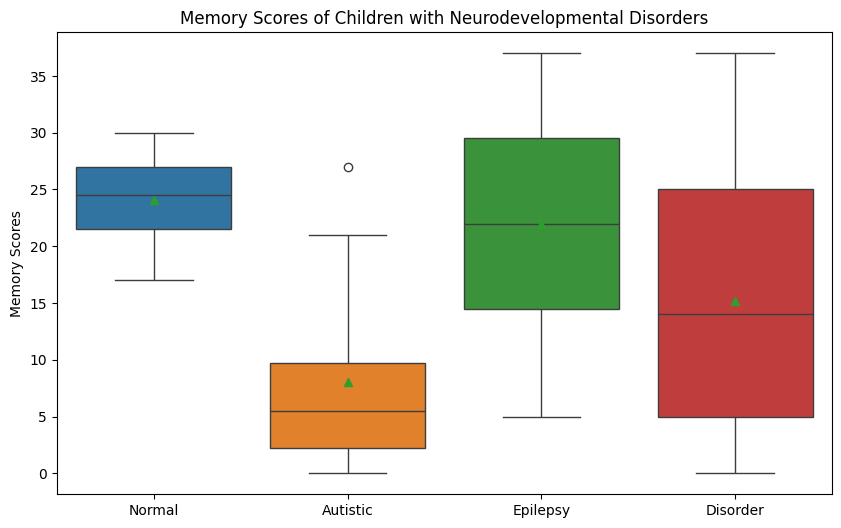

In [49]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=[data_normal, data_autistic, data_epilepsy,data_disorder], showmeans=True)
plt.xticks(ticks=[0, 1, 2,3], labels=['Normal', 'Autistic', 'Epilepsy','Disorder'])
plt.ylabel('Memory Scores')
plt.title('Memory Scores of Children with Neurodevelopmental Disorders')
plt.show()

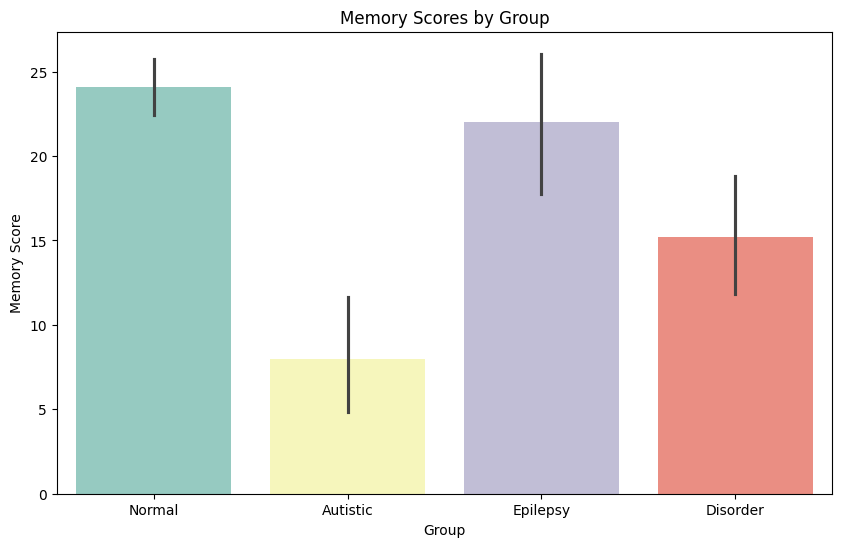

Error bars denote confidence intervals (CI) of 95%


In [50]:
groups = ['Normal'] * len(data_normal) + ['Autistic'] * len(data_autistic) + ['Epilepsy'] * len(data_epilepsy) + ['Disorder'] * len(data_disorder)
exam_scores = np.concatenate([data_normal, data_autistic, data_epilepsy,data_disorder])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=groups, y=exam_scores, errorbar=('ci', 95), palette="Set3" , hue=groups)
plt.title('Memory Scores by Group')
plt.xlabel('Group')
plt.ylabel('Memory Score')
plt.show()
print("Error bars denote confidence intervals (CI) of 95%")

# Driving Scores

In [51]:
## What extent of sleep deprivation affects driving ability ? 
## Condition 1 - same people in all 3 groups
## Condition 2 - different people in all 3 groups
one_night = np.array([15, 18, 20, 15, 12, 18, 16, 17, 14, 19, 20, 15, 16, 18, 19, 15, 17, 18, 17, 16])
two_night = np.array([10, 16, 13, 11, 9, 14, 13, 14, 15, 14, 12, 13, 14, 12, 11, 15, 14, 16, 12, 13])
three_night = np.array([5, 3, 9, 6, 4, 7, 8, 2, 4, 6, 9, 5, 3, 7, 1, 8, 7, 3, 6, 4])

In [52]:
group_stats = {
    'Groups': ['One-Night', 'Two-Night', 'Three-Night'],
    'Count': [len(one_night), len(two_night), len(three_night)],
    'Sum': [one_night.sum(), two_night.sum(), three_night.sum()],
    'Average': [one_night.mean(), two_night.mean(), three_night.mean()],
    'Variance': [one_night.var(), two_night.var(), three_night.var()]
}
group_stats_df = pd.DataFrame(group_stats) 
print(group_stats_df)

        Groups  Count  Sum  Average  Variance
0    One-Night     20  335    16.75    4.0875
1    Two-Night     20  261    13.05    3.3475
2  Three-Night     20  107     5.35    5.1275


#### Null Hypothesis (H0): There is no significant difference in driving scores among individuals experiencing different durations of sleep deprivation.

#### Alternative Hypothesis (H1): There is a significant difference in driving scores among individuals experiencing different durations of sleep deprivation.

## Check for Normality

In [53]:
shapiro_normality_tests = {}
for temp_data in one_night, two_night, three_night:
    stat, p = shapiro(temp_data)
    col = 'One-Night' if temp_data is one_night else 'Two-Night' if temp_data is two_night else 'Three-Night'
    shapiro_normality_tests[col] = {'Shapiro-Wilk Statistic': stat, 'p-value': p, 'Normality': p > 0.05}
    if p < 0.05:
        print(f"Data for {col} group is not normally distributed.")
        print("Kruskal-Wallis Test is used for non-parametric data.")

lilliefors_normality_tests = {}
for temp_data in one_night, two_night, three_night:
    n = len(temp_data)
    d, p = kstest(temp_data, 'norm', args=(np.mean(temp_data), np.std(temp_data, ddof=1)))
    col = 'One-Night' if temp_data is one_night else 'Two-Night' if temp_data is two_night else 'Three-Night'
    lilliefors_normality_tests[col] = {'Kolmogorov-Smirnov Statistic': d, 'p-value': p, 'Normality': p > 0.05}

print("Shapiro Normality Tests:")
print(pd.DataFrame(shapiro_normality_tests))
print("\n")
print("Kolmogorov-Smirnov Tests with Lilliefors Significance Correction:")
print(pd.DataFrame(lilliefors_normality_tests))

Shapiro Normality Tests:
                       One-Night Two-Night Three-Night
Shapiro-Wilk Statistic  0.961926  0.960936    0.963007
p-value                    0.583   0.56272    0.605514
Normality                   True      True        True


Kolmogorov-Smirnov Tests with Lilliefors Significance Correction:
                             One-Night Two-Night Three-Night
Kolmogorov-Smirnov Statistic  0.126619  0.143602     0.11941
p-value                       0.866363   0.75198    0.906136
Normality                         True      True        True


### Check homogeneity of variances

In [54]:
levene_mean = levene(one_night, two_night, three_night, center='mean')
levene_median = levene(one_night, two_night, three_night, center='median')
levene_trimmed_mean = levene(one_night, two_night, three_night, center='trimmed',proportiontocut=0.1)
levene_adjusted_df = levene(one_night, two_night, three_night, center='trimmed', proportiontocut=0.05)
print("\nHomogeneity of Variances Test:")
levene_test = pd.DataFrame({
    'Center': ['Mean', 'Median', 'Trimmed Mean'],
    'Test-Statistic': [levene_mean.statistic, levene_median.statistic, levene_trimmed_mean.statistic],
    'p-value': [levene_mean.pvalue, levene_median.pvalue, levene_trimmed_mean.pvalue]
})
print(levene_test)
if levene_mean.pvalue > 0.05:
    print("Variance is homogenous based on mean")
elif levene_median.pvalue > 0.05:
    print("Variance is homogenous based on median")
elif levene_trimmed_mean.pvalue > 0.05:
    print("Variance is homogenous based on trimmed mean")
elif levene_adjusted_df.pvalue > 0.05:
    print("Variance is homogenous based on trimmed mean with 5% proportion to cut")
else:
    print("Variance is not homogenous")


Homogeneity of Variances Test:
         Center  Test-Statistic   p-value
0          Mean        0.913645  0.406852
1        Median        0.897452  0.413288
2  Trimmed Mean        1.783721  0.179686
Variance is homogenous based on mean


### Check for sphericity of variances

In [55]:
data = pd.DataFrame({
    'One-Night': one_night,
    'Two-Night': two_night,
    'Three-Night': three_night
})
mauchly_test = pg.sphericity(data)
print(mauchly_test)
print("Mauchly's Sphericity Test:")
if mauchly_test[4] > 0.05:
    print("Sphericity assumption is met.")
    print("Repeated Measures ANOVA test is used for parametric data.")
else:
    print("Sphericity assumption is not met.")
    print("Friedman Test is used for non-parametric data.")

SpherResults(spher=True, W=0.9171200343766543, chi2=1.5573044933841214, dof=2, pval=0.45902424604371417)
Mauchly's Sphericity Test:
Sphericity assumption is met.
Repeated Measures ANOVA test is used for parametric data.


## Condition 1 - Same people in all 3 groups

## Repeated Measures ANOVA

In [56]:
repeated_anova = pg.rm_anova(data=pd.DataFrame({'One-Night': one_night, 'Two-Night': two_night, 'Three-Night': three_night}))
repeated_anova_detailed = pg.rm_anova(data=pd.DataFrame({'One-Night': one_night, 'Two-Night': two_night, 'Three-Night': three_night}), detailed=True,effsize='np2')
print("Repeated Measures ANOVA Test:")
print(repeated_anova_detailed.to_string())
print("\nWithin Subjects ANOVA Test:")
print(repeated_anova)
p_value = repeated_anova['p-unc'][0]
f_stat = repeated_anova['F'][0]

Repeated Measures ANOVA Test:
   Source           SS  DF          MS           F         p-unc       np2       eps
0  Within  1352.933333   2  676.466667  178.017544  5.020250e-20  0.903562  0.923463
1   Error   144.400000  38    3.800000         NaN           NaN       NaN       NaN

Within Subjects ANOVA Test:
   Source  ddof1  ddof2           F         p-unc       ng2       eps
0  Within      2     38  178.017544  5.020250e-20  0.843378  0.923463


In [57]:
data_long = pd.melt(data.reset_index(), id_vars=['index'], value_vars=['One-Night', 'Two-Night', 'Three-Night'])
data_long.columns = ['Subject', 'Night', 'Score']
rm_anova = AnovaRM(data_long, 'Score', 'Subject', within=['Night']).fit()
print("\nRepeated Measures ANOVA Test:")
print(rm_anova.summary())

if p_value < 0.05:
    print("There is a significant difference between the groups.")
    print("Main effect (F) is significant.")
else:
    print("There is no significant difference between the groups.")
    print("Main effect (F) is not significant. No post-hoc test performed.")

alpha = 0.05
df = 2
H_critical = f.ppf(1 - alpha,df,df)
print("\nF Critical Value:")
print(f"F-critical value: {H_critical}")

if f_stat > H_critical:
    print("There is a significant difference between groups. Reject the null hypothesis. Using a one way repeated measures ANOVA we observed that there was difference in scores across the 3 timepoints ")
else:
    print("There is no significant difference between groups. Fail to reject the null hypothesis. Using a one way repeated measures ANOVA we observed that there was no difference in scores across the 3 timepoints ")


Repeated Measures ANOVA Test:
               Anova
      F Value  Num DF  Den DF Pr > F
------------------------------------
Night 178.0175 2.0000 38.0000 0.0000

There is a significant difference between the groups.
Main effect (F) is significant.

F Critical Value:
F-critical value: 18.999999999999982
There is a significant difference between groups. Reject the null hypothesis. Using a one way repeated measures ANOVA we observed that there was difference in scores across the 3 timepoints 


## Tukey's Post-Hoc Test


Post-hoc Tukey's HSD Test:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj  lower    upper  reject
--------------------------------------------------------------
  One-Night Three-Night    -11.4   0.0 -12.9977 -9.8023   True
  One-Night   Two-Night     -3.7   0.0  -5.2977 -2.1023   True
Three-Night   Two-Night      7.7   0.0   6.1023  9.2977   True
--------------------------------------------------------------


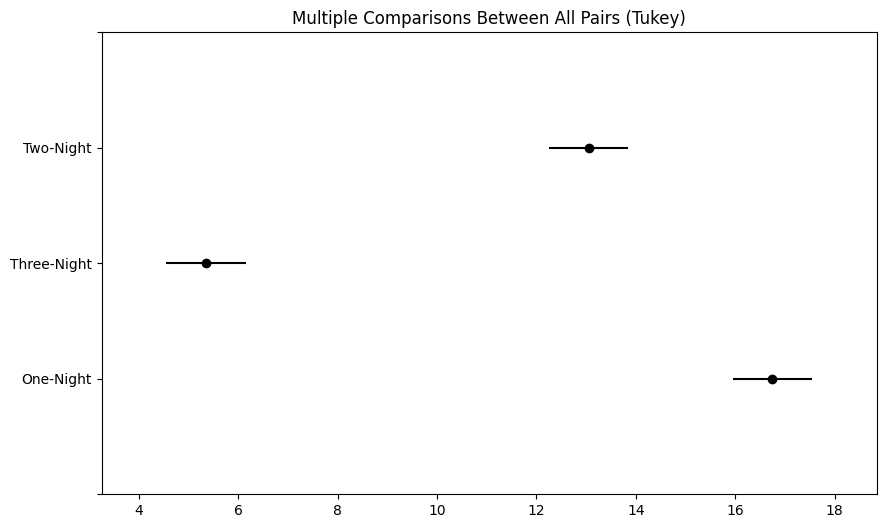


Tukey's HSD value:
7.846159711745755
There is a significant difference between the groups. Reject the null hypothesis.


In [58]:
data_long = pd.melt(data.reset_index(), id_vars=['index'], value_vars=['One-Night', 'Two-Night', 'Three-Night'])
tukey_result = pairwise_tukeyhsd(data_long['value'], data_long['variable'])
print("\nPost-hoc Tukey's HSD Test:")
print(tukey_result)
tukey_df = tukey_result.summary()
tukey_hsd = tukey_result.meandiffs.std()
tukey_result.plot_simultaneous()
plt.show()
print("\nTukey's HSD value:")
print(tukey_hsd)
q_critical = tukey_result.q_crit
if tukey_hsd > q_critical:
    print("There is a significant difference between the groups. Reject the null hypothesis.")
else:
    print("There is no significant difference between the groups. Fail to reject the null hypothesis.")

## Condition 1 - Conclusion
### Shapiro Normality Tests:

Based on the Shapiro-Wilk statistic and p-values, normality is assumed for each group (One-Night, Two-Night, Three-Night).

### Homogeneity of Variances Test:

Variance is considered homogeneous based on the mean.

### Mauchly's Sphericity Test:

Sphericity assumption is met.

### Repeated Measures ANOVA Test:

- There is a significant difference between the groups (p < 0.05).
- The effect size (np2) is substantial (0.903562), indicating a large effect.
- The epsilon value (eps) is close to 1, suggesting that the assumption of sphericity is reasonable.

### Tukey's HSD value:

The Tukey's Honestly Significant Difference (HSD) value is calculated as 7.846.
Since there is a significant difference between the groups, we reject the null hypothesis.

Based on these results, we can conclude that sleep deprivation significantly affects driving ability, and there are discernible differences among the groups across the three time points.


## Condition 2 - Different people in all 3 groups

## One-way ANOVA

In [59]:
k = 3
N = len(one_night) + len(two_night) + len(three_night)
group_means = [np.mean(one_night), np.mean(two_night), np.mean(three_night)]
grand_mean = np.mean([np.mean(one_night), np.mean(two_night), np.mean(three_night)])
SSb = sum([len(one_night) * (group_means[0] - grand_mean) ** 2,
           len(two_night) * (group_means[1] - grand_mean) ** 2,
           len(three_night) * (group_means[2] - grand_mean) ** 2])
dfb = k-1
MSb = SSb / dfb
SSw = sum([(x - group_means[i]) ** 2 for i, data in enumerate([one_night,two_night,three_night]) for x in data])
dfw = N-k
MSw = SSw / dfw
F_value = MSb / MSw
alpha = 0.05
F_crit = f.ppf(1 - alpha, dfb, dfw)
p_value = 1-f.cdf(F_value, dfb, dfw)


anova_table = [
    ["Between Groups", f"{SSb:.6f}", dfb, f"{MSb:.6f}"],
    ["Within Groups", f"{SSw:.6f}", dfw, f"{MSw:.6f}"],
    ["Total", f"{SSb+SSw:.6f}", dfb+dfw]
]

print("ANOVA Table")
print(tabulate(anova_table, headers=["Source of Variation", "SS", "df", "MS"], tablefmt="pretty"))

anova_table = [
    ["Between Groups", f"{F_value:.6f}",f"{p_value}" ,f"{F_crit:.6f}"],
    ["Within Groups"],
    ["Total"]
]
print("\nANOVA Table")
print(tabulate(anova_table, headers=["Source of Variation", "F", "p-value","F crit"], tablefmt="pretty"))

ANOVA Table
+---------------------+-------------+----+------------+
| Source of Variation |     SS      | df |     MS     |
+---------------------+-------------+----+------------+
|   Between Groups    | 1352.933333 | 2  | 676.466667 |
|    Within Groups    | 251.250000  | 57 |  4.407895  |
|        Total        | 1604.183333 | 59 |            |
+---------------------+-------------+----+------------+

ANOVA Table
+---------------------+------------+------------------------+----------+
| Source of Variation |     F      |        p-value         |  F crit  |
+---------------------+------------+------------------------+----------+
|   Between Groups    | 153.467065 | 1.1102230246251565e-16 | 3.158843 |
|    Within Groups    |            |                        |          |
|        Total        |            |                        |          |
+---------------------+------------+------------------------+----------+


In [60]:
anova_result = f_oneway(one_night, two_night, three_night)
print("\nOne-way ANOVA Test:")
print(f"F-statistic: {anova_result.statistic}")
print(f"p-value: {anova_result.pvalue}")

if anova_result.pvalue < 0.05:
    print("\nSince p-value < 0.05, there are significant differences between groups. Using a one way ANOVA we observed that the extent of sleep deprivation affects driving ability.")
else:
    print("\nNo significant differences between groups.")


One-way ANOVA Test:
F-statistic: 153.46706467661707
p-value: 1.1305349928649485e-23

Since p-value < 0.05, there are significant differences between groups. Using a one way ANOVA we observed that the extent of sleep deprivation affects driving ability.


## Effect-size calculation

In [61]:
Effect_size = SSb / (SSb + SSw)
print(f"Effect Size: {Effect_size:.6f}")
print(f"Extent of sleep deprivation explains {Effect_size:.6f} of the variance in driving ability.")

Effect Size: 0.843378
Extent of sleep deprivation explains 0.843378 of the variance in driving ability.


## Group-wise comparison using t-test with bonferroni correction

In [62]:
t_statistic_one_two, p_value_one_two = ttest_ind(one_night, two_night)
t_statistic_two_three, p_value_two_three = ttest_ind(two_night, three_night)
t_statistic_three_one, p_value_three_one = ttest_ind(three_night, one_night)

alpha = 0.05
alpha_corrected = alpha / 3 

print("alpha corrected: ", alpha_corrected)

p_value_one_two_corrected = p_value_one_two * 3
p_value_two_three_corrected = p_value_two_three * 3
p_value_three_one_corrected = p_value_three_one * 3

table_data = [
    ['Groupwise comparisons', 'T-test p-value', 'Bonferroni-corrected p-value'],
    ['One-Night vs Two-Night', p_value_one_two, p_value_one_two_corrected],
    ['Two-Night vs Three-Night', p_value_two_three, p_value_two_three_corrected],
    ['Three-Night vs One-Night', p_value_three_one, p_value_three_one_corrected]
]
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

alpha corrected:  0.016666666666666666
+--------------------------+------------------+--------------------------------+
| Groupwise comparisons    |   T-test p-value |   Bonferroni-corrected p-value |
+==========================+==================+================================+
| One-Night vs Two-Night   |      7.45169e-07 |                    2.23551e-06 |
+--------------------------+------------------+--------------------------------+
| Two-Night vs Three-Night |      5.66876e-14 |                    1.70063e-13 |
+--------------------------+------------------+--------------------------------+
| Three-Night vs One-Night |      8.40921e-19 |                    2.52276e-18 |
+--------------------------+------------------+--------------------------------+


## Holm method for multiple comparisons

In [63]:
datasets = [('Normal', data_normal), ('Autistic', data_autistic), ('Epilepsy', data_epilepsy)]
alpha = 0.05
p_values = []
for i in range(len(datasets)):
    for j in range(i + 1, len(datasets)):
        group1_name, group1_data = datasets[i]
        group2_name, group2_data = datasets[j]
        t_stat, p_value = ttest_ind(group1_data, group2_data)
        p_values.append(p_value)

table = []
table.append(['Group 1', 'Group 2', 'Significant Difference', 'p-corrected'])
reject, p_values_corrected, _, _ = multipletests(p_values, alpha=alpha, method='holm')
index = 0
for i in range(len(datasets)):
    for j in range(i + 1, len(datasets)):
        group1_name, _ = datasets[i]
        group2_name, _ = datasets[j]
        if reject[index]:
            print(f"There is a significant difference between {group1_name} and {group2_name} (p-corrected = {p_values_corrected[index]})\n")
            table.append([group1_name, group2_name, "Yes", f"{p_values_corrected[index]}"])
        else:
            print(f"No significant difference between {group1_name} and {group2_name} (p-corrected = {p_values_corrected[index]})\n")
            table.append([group1_name, group2_name, "No", f"{p_values_corrected[index]}"])
        index += 1
print(tabulate(table, headers='firstrow', tablefmt='grid'))

There is a significant difference between Normal and Autistic (p-corrected = 1.7871272588070343e-09)

No significant difference between Normal and Epilepsy (p-corrected = 0.3816292163425007)

There is a significant difference between Autistic and Epilepsy (p-corrected = 5.356022164570678e-05)

+-----------+-----------+--------------------------+---------------+
| Group 1   | Group 2   | Significant Difference   |   p-corrected |
+===========+===========+==========================+===============+
| Normal    | Autistic  | Yes                      |   1.78713e-09 |
+-----------+-----------+--------------------------+---------------+
| Normal    | Epilepsy  | No                       |   0.381629    |
+-----------+-----------+--------------------------+---------------+
| Autistic  | Epilepsy  | Yes                      |   5.35602e-05 |
+-----------+-----------+--------------------------+---------------+


## Tukey's Post-Hoc Test

In [64]:
if anova_result.pvalue < 0.05:
    data_melted = pd.melt(data)
    posthoc = pairwise_tukeyhsd(data_melted['value'], data_melted['variable'], alpha=0.05)
    print(posthoc)
    print(posthoc.q_crit) 
    HSD = posthoc.q_crit*np.sqrt(MSw / len(data))
    print(f"HSD: {HSD:.6f}")
    print(f"The mean difference between any two samples must be more than {HSD:.6f} at alpha = 0.05 for the difference to be statistically significant")

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj  lower    upper  reject
--------------------------------------------------------------
  One-Night Three-Night    -11.4   0.0 -12.9977 -9.8023   True
  One-Night   Two-Night     -3.7   0.0  -5.2977 -2.1023   True
Three-Night   Two-Night      7.7   0.0   6.1023  9.2977   True
--------------------------------------------------------------
3.403189192594075
HSD: 1.597669
The mean difference between any two samples must be more than 1.597669 at alpha = 0.05 for the difference to be statistically significant


## Condition 2 - Conclusion
### Shapiro Normality Tests:

Based on the Shapiro-Wilk statistic and p-values, normality is assumed for each group (One-Night, Two-Night, Three-Night).

### Homogeneity of Variances Test:

Variance is considered homogeneous based on the mean.

### Mauchly's Sphericity Test:

Sphericity assumption is met.

### One-way ANOVA Test:

- F-statistic: 153.47
- p-value: 1.13e-23
- Since p-value < 0.05, there are significant differences between groups. Using a one-way ANOVA, we observed that the extent of sleep deprivation affects driving ability.
- Effect Size: 0.843378 (Extent of sleep deprivation explains 84.34% of the variance in driving ability)
- HSD (Honestly Significant Difference): 1.597669. The mean difference between any two samples must be more than 1.597669 at alpha = 0.05 for the difference to be statistically significant.

### Groupwise Comparisons:
These results suggest significant differences in driving ability between groups across different extents of sleep deprivation.


## Plot Analysed data

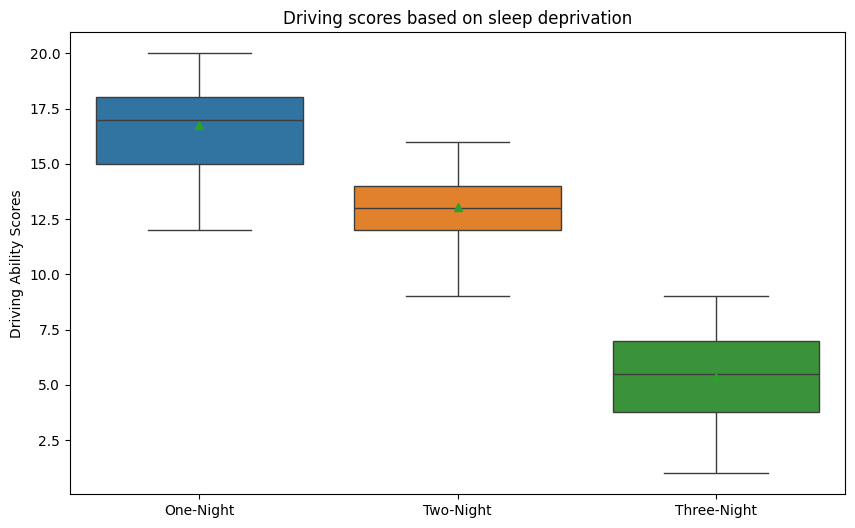

In [65]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=[one_night, two_night, three_night], showmeans=True)
plt.xticks(ticks=[0, 1, 2], labels=['One-Night', 'Two-Night', 'Three-Night'])
plt.ylabel('Driving Ability Scores')
plt.title('Driving scores based on sleep deprivation')
plt.show()

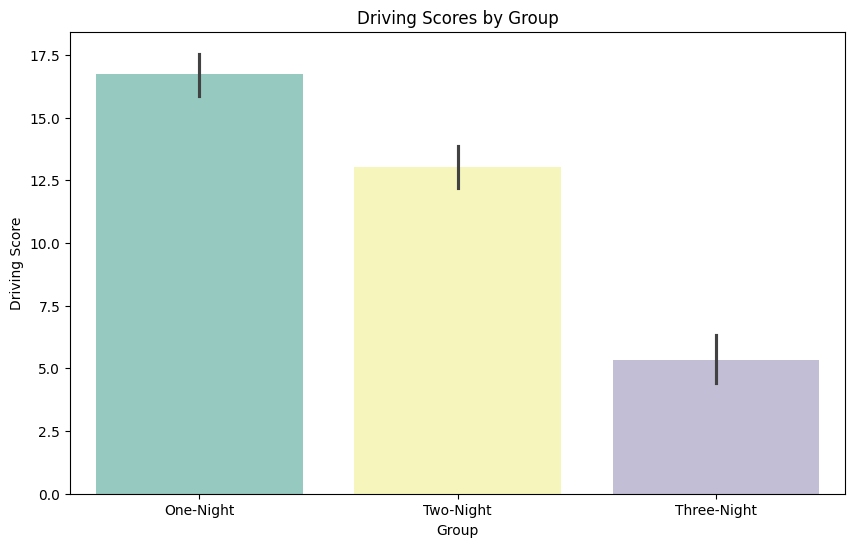

Error bars denote confidence intervals (CI) of 95%


In [66]:
groups = ['One-Night'] * len(one_night) + ['Two-Night'] * len(two_night) + ['Three-Night'] * len(three_night)
driving_scores = np.concatenate([one_night, two_night, three_night])

plt.figure(figsize=(10, 6))
sns.barplot(x=groups, y=driving_scores, errorbar=('ci', 95), palette="Set3" , hue=groups)
plt.title('Driving Scores by Group')
plt.xlabel('Group')
plt.ylabel('Driving Score')
plt.show()
print("Error bars denote confidence intervals (CI) of 95%")